In [ ]:

!pip install yfinance --quiet
!pip install tensorflow --quiet
!pip install scikit-learn --quiet
!pip install matplotlib --quiet


In [ ]:
# Cell 0: imports and seeds
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:
# Cell 1: download data (change ticker & period if you want)
ticker = 'AAPL'         # change this to any ticker
period = '5y'           # e.g., '3y', '10y'
interval = '1d'         # daily data

df = yf.download(ticker, period=period, interval=interval, progress=False)
df = df[['Close']]      # use Close price
df.dropna(inplace=True)
df.head()


/tmp/ipython-input-972734012.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval, progress=False)


Price,Close
Ticker,AAPL
Date,
2020-10-15,117.416756
2020-10-16,115.772873
2020-10-19,112.815811
2020-10-20,114.304070
2020-10-21,113.681526


Rows: 1255, Date range: 2020-10-15 to 2025-10-14


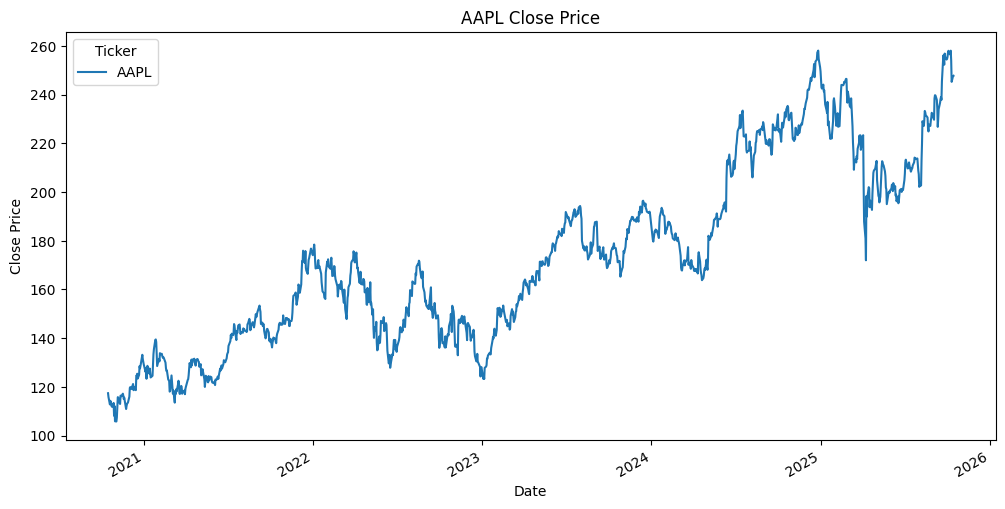

In [ ]:
# Cell 2: quick EDA
print(f"Rows: {len(df)}, Date range: {df.index.min().date()} to {df.index.max().date()}")
df['Close'].plot(title=f"{ticker} Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


In [ ]:
# Cell 3: create sequences for LSTM
sequence_length = 60    # number of past days used to predict next day

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)  # shape (n_samples, 1)

def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    # reshape X for LSTM: (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

X, y = create_sequences(scaled, sequence_length)
print("X shape:", X.shape, "y shape:", y.shape)


X shape: (1195, 60, 1) y shape: (1195,)


In [ ]:
# Cell 4: time-based split (no shuffling)
train_ratio = 0.8
train_size = int(len(X) * train_ratio)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])



Train samples: 956 Test samples: 239


In [ ]:
# Cell 5: model definition
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)  # predict scaled close price
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0894

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0863 - val_loss: 0.0107
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0085

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0049 - val_loss: 0.0078
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0037

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0038

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 7/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0034

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0031 - val_loss: 0.0076
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0030 - val_loss: 0.0128
Epoch 12/50
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0028

30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0024 - val_loss: 0.0049
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0023 - val_loss: 0.0115
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 18/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0020 - val_loss: 0.0043


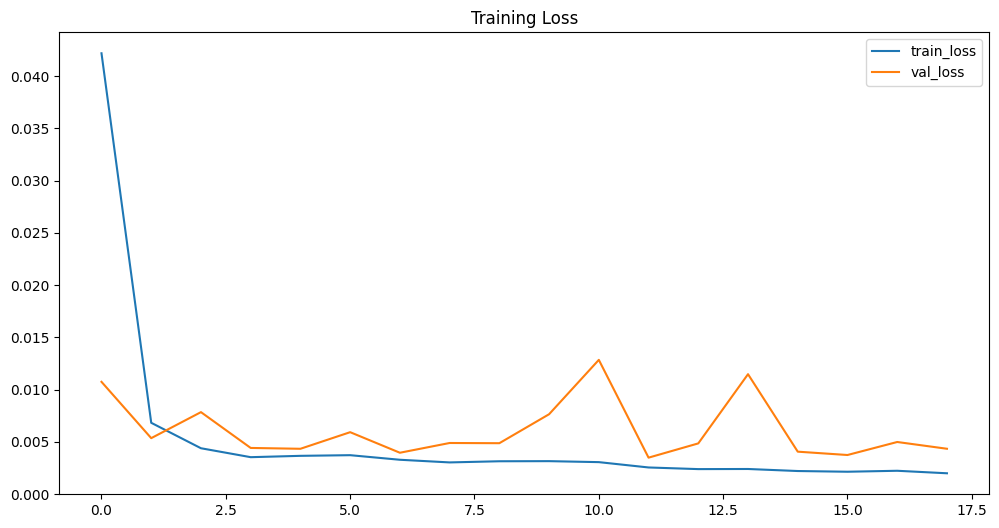

In [ ]:
# Cell 6: training
epochs = 50
batch_size = 32

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    # optional: save best model
    ModelCheckpoint('best_lstm.h5', monitor='val_loss', save_best_only=True, verbose=0)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Plot loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Training Loss')
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Test RMSE: 8.9928


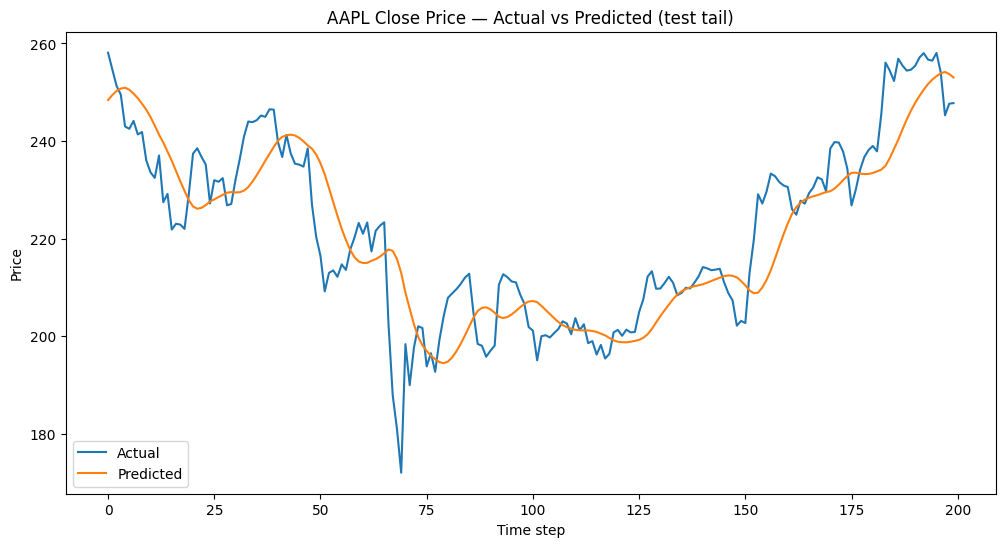

In [ ]:
# Cell 7: predict and invert scaling
y_pred_scaled = model.predict(X_test)
# Need to inverse transform: scaler expects 2D shaped inputs
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1))

# compute metrics
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print(f"Test RMSE: {rmse:.4f}")

# Plot actual vs predicted (last 200 points or whole test set)
n_plot = min(200, len(y_true))
plt.plot(y_true[-n_plot:], label='Actual')
plt.plot(y_pred[-n_plot:], label='Predicted')
plt.title(f"{ticker} Close Price — Actual vs Predicted (test tail)")
plt.xlabel("Time step")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
# Cell 8: next-day forecast
last_seq = scaled[-sequence_length:]            # last 60 scaled values
last_seq = last_seq.reshape((1, sequence_length, 1))
next_pred_scaled = model.predict(last_seq)
next_pred = scaler.inverse_transform(next_pred_scaled)[0,0]
print(f"Predicted next-day Close price for {ticker}: {next_pred:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted next-day Close price for AAPL: 252.1626


In [ ]:
# Cell 9: forecast n future days (naive: feed predicted back)
def forecast_n_days(model, last_sequence_scaled, n_days, scaler):
    seq = last_sequence_scaled.copy().reshape(-1).tolist()
    preds = []
    for _ in range(n_days):
        arr = np.array(seq[-sequence_length:]).reshape(1, sequence_length, 1)
        p_scaled = model.predict(arr)[0,0]
        seq.append(p_scaled)   # append scaled prediction
        preds.append(p_scaled)
    preds = np.array(preds).reshape(-1, 1)
    preds_inv = scaler.inverse_transform(preds)
    return preds_inv.flatten()

n_days = 7
future_preds = forecast_n_days(model, scaled[-sequence_length:], n_days, scaler)
for i, p in enumerate(future_preds, 1):
    print(f"Day +{i}: {p:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Day +1: 252.1626
Day +2: 251.4371
Day +3: 250.7710
Day +4: 250.1511
Day +5: 249.5686
Day +6: 249.0167
Day +7: 248.4893


In [ ]:
# Cell 10: save artifacts
model.save('lstm_stock_model.h5')
import joblib
joblib.dump(scaler, 'scaler.save')
print("Saved model and scaler to disk.")


Saved model and scaler to disk.
